In [9]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# comp-linguistics
import scipy
import spacy
import en_core_web_sm
import nltk

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(2020)

### Loading and Cleaning the data

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_review.csv")
df_meta = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_meta.csv")
df.shape

(5511, 14)

In [11]:
df_meta

,Unnamed: 0,overall,asin,category,description,title,image,brand,feature,rank,main_cat,date,price,also_buy,also_view,similar_item,tech1,tech2,details,fit
0,92,2567,B000A6PPOK,"['Electronics', 'Computers & Accessories', 'Co...",['USB'],Microsoft Natural Ergonomic Keyboard 4000,['https://images-na.ssl-images-amazon.com/imag...,Microsoft,['Split ergonomic design encourages natural ha...,['>#222 in Computers & Accessories > Computer ...,All Electronics,27-Sep-17,$48.50,"['B00FPAVUHC', 'B0043T7FXE', 'B001F42MKG', 'B0...","['B075GZVD4T', 'B002MMY4WY', 'B00CYX26BC', 'B0...","[{'asin': '', 'href': '', 'name': 'Microsoft N...",NaN,NaN,NaN,NaN
1,191,1805,B00I0S6SK0,"['Electronics', 'Computers & Accessories', 'Co...",['The AZiO Vision keyboard features extra larg...,Azio Vision Backlit USB Keyboard with Large Pr...,['https://images-na.ssl-images-amazon.com/imag...,Azio,['Easy to see large print keys. 2x Larger than...,['>#56 in Computers & Accessories > Computer A...,Computers,21-Oct-17,$2.54,"['B00ERV026K', 'B0787QZ6WD', 'B075WW7V6W', 'B0...","['B003VAGXWK', 'B00AGI7NKG', 'B007ZUC7DG', 'B0...","[{'asin': '', 'href': '', 'name': 'Azio Vision...",{'Number of USB 2.0 Ports': '1'},"{'Brand Name': 'Azio', 'Item model number': 'K...",NaN,NaN
2,2263,418,B00E4TOWR0,"['Electronics', 'Computers & Accessories', 'Co...","[""Get-more-done productivity: Achieve more wit...",HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),['https://images-na.ssl-images-amazon.com/imag...,HP,['Get-more-done productivity: Achieve more wit...,['>#25 in Computers & Accessories > Computer A...,Computers,28-Jul-17,$14.99,NaN,"['B005EOWBHC', 'B00ZYLMQH0', 'B004YDSPSS', 'B0...","[{'asin': '', 'href': '', 'name': 'HP Wired US...","{'Brand Name': 'HP', 'Series': 'H3C52AA', 'Ite...",NaN,NaN,NaN
3,2620,378,B00LSGKEC4,"['Electronics', 'Computers & Accessories', 'Co...",NaN,Redragon K502 Gaming Keyboard RGB LED Backlit ...,['https://images-na.ssl-images-amazon.com/imag...,Redragon,['SILENT GAMING KEYBOARD; 104 Key Gaming Keybo...,>#263 in Computers & Accessories > Computer Ac...,Computers,28-Jul-17,$28.99,"['B00HTK1NCS', 'B011HMDZ0Q', 'B00GU4F4OM', 'B0...","['B073DBS35C', 'B074DRFHYS', 'B01EOH2JLW', 'B0...","[{'asin': '', 'href': '', 'name': 'Redragon K5...","{'Brand Name': 'Redragon', 'Series': 'K502 Kar...",NaN,NaN,NaN
4,2962,343,B0194MC7JG,"['Electronics', 'Computers & Accessories', 'Co...",['ONE WIRELESS KEYBOARD AND MOUSE SET FOR WIRE...,Wireless Keyboard and Mouse - Jelly Comb K025 ...,['https://images-na.ssl-images-amazon.com/imag...,Jelly Comb,['RELIABLE 2.4GHz WIRELESS CONNECTION: 10m or ...,['>#323 in Computers & Accessories > Computer ...,Computers,18-Jul-18,$2.54,"['B01B4RWTAG', 'B001CJRM36', 'B0181JTPCU', 'B0...",NaN,"[{'asin': '', 'href': '', 'name': 'Wireless Ke...",NaN,NaN,NaN,NaN


In [12]:
tbl = df.groupby('asin').agg({'overall':'count'})
tbl = tbl.sort_values(by = ['overall'], ascending = False)
tbl['asin'] = tbl.index
tbl = tbl.rename_axis("ID")
tbl

,overall,asin
ID,,
B000A6PPOK,2567,B000A6PPOK
B00I0S6SK0,1805,B00I0S6SK0
B00E4TOWR0,418,B00E4TOWR0
B00LSGKEC4,378,B00LSGKEC4
B0194MC7JG,343,B0194MC7JG


We downsampled it into ~350 variables per product to make it more normally distributed among different products.

In [13]:
# downsampling
df_sample = df[df['asin'] == tbl.index[-1]]
for i in range(4):
    df_temp = df[df['asin'] == tbl.index[i]].sample(n=350)
    df_sample = df_sample.append(df_temp)
df_sample.shape

(1743, 14)

In [14]:
df_sample = df_sample[df_sample['reviewText'].notnull()]
df_agg = df_sample.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
df_agg

,asin,title,reviewText
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,I tried lots of eco keyboards. This is the bes...
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),"Membrane keyboard can get stuck, and broke aft..."
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,If you are looking for a lighted keyboard for ...
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,I ordered this keyboard after much debating an...
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...


In [15]:
df_agg['tokenized_words'] = df_agg['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_agg['normalized_words'] = df_agg['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,I tried lots of eco keyboards. This is the bes...,"[I, tried, lots, of, eco, keyboards, This, is,...","[tried, lots, eco, keyboards, best, years, hap..."
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),"Membrane keyboard can get stuck, and broke aft...","[Membrane, keyboard, can, get, stuck, and, bro...","[membrane, keyboard, stuck, broke, months, lit..."
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,If you are looking for a lighted keyboard for ...,"[If, you, are, looking, for, a, lighted, keybo...","[looking, lighted, keyboard, best, price, sigh..."
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,I ordered this keyboard after much debating an...,"[I, ordered, this, keyboard, after, much, deba...","[ordered, keyboard, debating, searching, onlin..."
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


## EDA

HW1. Counting Words

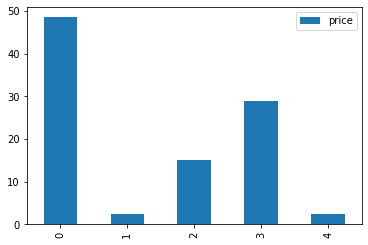

In [16]:
test = df_meta[['asin', 'price']]
for index, _ in test.iterrows():
    test['price'][index] = float(test['price'][index][1:])
test.plot(kind='bar')

In [17]:
# Plot the mean of overall, vote and verified
for index, _ in df.iterrows():
    df['vote'].fillna(value=0,inplace=True)
    if not df['vote'][index]:
        continue
    if ',' in df['vote'][index]:
        df['vote'][index] = df['vote'][index].replace(',', '')

df['vote'] = df['vote'].astype('int')
tbl2 = df.groupby('asin').mean()
tbl2

,Unnamed: 0,overall,vote,verified,unixReviewTime
asin,,,,,
B000A6PPOK,1283.0,4.206467,1.112193,0.862875,1.399060e+09
B00E4TOWR0,2775.5,4.363636,0.435407,0.937799,1.486965e+09
B00I0S6SK0,3887.0,4.247091,0.657618,0.954017,1.435643e+09
B00LSGKEC4,4978.5,3.886243,0.716931,0.970899,1.464486e+09
B0194MC7JG,5339.0,3.953353,0.437318,0.965015,1.482945e+09


In [19]:
# Counting words borrowed from materials
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

a. Counting: Most Frequent Words (normalized)

In [20]:
# Aggregate to a huge list
ls_normalized_words = []
for row in df_agg.iterrows():
    ls_normalized_words += row[-1]['normalized_words']
len(ls_normalized_words)

42040

In [21]:
df_words_count = wordCounter(ls_normalized_words)
df_words_count.sort_values('count', ascending=False, inplace=True)
df_words_count.head(10)

,word,count
16,keyboard,2258
133,keys,983
178,like,517
63,key,483
85,great,462
20,use,406
219,good,338
104,mouse,337
3,keyboards,289
519,love,274


b. Visualization (Lexical Plot and WordCloud)

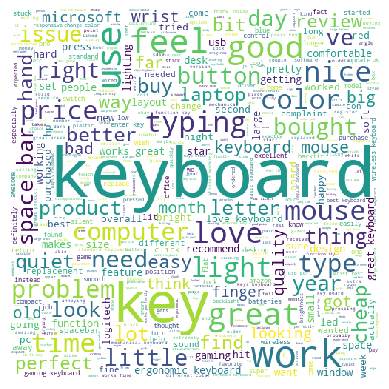

In [24]:
# Word Cloud
import wordcloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(df_agg['normalized_words'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("song_lyrics_word_cloud.pdf", format = 'pdf')

c. Sentimental Analysis

In [25]:
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,I tried lots of eco keyboards. This is the bes...,"[I, tried, lots, of, eco, keyboards, This, is,...","[tried, lots, eco, keyboards, best, years, hap..."
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),"Membrane keyboard can get stuck, and broke aft...","[Membrane, keyboard, can, get, stuck, and, bro...","[membrane, keyboard, stuck, broke, months, lit..."
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,If you are looking for a lighted keyboard for ...,"[If, you, are, looking, for, a, lighted, keybo...","[looking, lighted, keyboard, best, price, sigh..."
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,I ordered this keyboard after much debating an...,"[I, ordered, this, keyboard, after, much, deba...","[ordered, keyboard, debating, searching, onlin..."
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


In [26]:
# Overall Sentiment Score
from textblob import TextBlob

df_agg['sentiment'] = float(0)
for index, row in df_agg.iterrows():
    obj = TextBlob(' '.join(df_agg['normalized_words'][index]))
    sentiment = obj.sentiment.polarity
    df_agg['sentiment'][index] = sentiment
df_senti = df_agg[['asin', 'sentiment']].sort_values('sentiment', ascending=False)
df_senti

,asin,sentiment
1,B00E4TOWR0,0.232226
4,B0194MC7JG,0.212755
2,B00I0S6SK0,0.212678
3,B00LSGKEC4,0.187599
0,B000A6PPOK,0.159974


In [27]:
df_sample['tokenized_words'] = df_sample['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_sample['normalized_words'] = df_sample['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
df_sample.head()

,Unnamed: 0,asin,title,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image,tokenized_words,normalized_words
5168,5168,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,5.0,16,False,"01 22, 2016",A34KGD6ZYDDVT0,{'Color:': ' Yellow'},ChalmondFashew,I didn't think it would be possible with this ...,Loving this set. Works flawlessly on my Linux ...,1453420800,['https://images-na.ssl-images-amazon.com/imag...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."
5169,5169,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,5.0,NaN,False,"01 19, 2016",A2YXQMZ32BY8XH,{'Color:': ' Yellow'},IAMM3Z,I work remotely and occasionally need to trave...,Truly is a softer & quieter experience,1453161600,['https://images-na.ssl-images-amazon.com/imag...,"[I, work, remotely, and, occasionally, need, t...","[work, remotely, occasionally, need, travel, o..."
5170,5170,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,2.0,NaN,True,"07 24, 2018",A286VUZ1TBV0VF,{'Color:': ' Black and Yellow'},MJS Marietta GA,Setup was easy. Do not like the placement of ...,Did not deliver for me...,1532390400,NaN,"[Setup, was, easy, Do, not, like, the, placeme...","[setup, easy, like, placement, page, control, ..."
5171,5171,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,4.0,NaN,True,"07 22, 2018",A2B425NY1IZKXS,{'Color:': ' Yellow'},ShoeLover9989,The yellow one is not whisper quite like the g...,The yellow trimmed design is not whisper quiet...,1532217600,NaN,"[The, yellow, one, is, not, whisper, quite, li...","[yellow, whisper, like, green, ordered, read, ..."
5172,5172,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,3.0,NaN,True,"07 4, 2018",A1RD4GL359K9TD,{'Color:': ' Black and Yellow'},jx yao,Need extra force for an angled key press.,Keys too stiff,1530662400,NaN,"[Need, extra, force, for, an, angled, key, press]","[need, extra, force, angled, key, press]"


In [28]:
# Calculating Sentiment for each review
df_sample['sentiment'] = float(0)
for index, row in df_sample.iterrows():
    obj = TextBlob(' '.join(df_sample['normalized_words'][index]))
    sentiment = obj.sentiment.polarity
    df_sample['sentiment'][index] = sentiment
df_senti_2 = df_sample[['asin', 'sentiment']]
df_senti_2 = df_senti_2.groupby('asin').mean().sort_values('sentiment', ascending=False)
df_senti_2

,sentiment
asin,
B00E4TOWR0,0.317637
B0194MC7JG,0.294846
B00I0S6SK0,0.291178
B00LSGKEC4,0.250436
B000A6PPOK,0.236878


These two sentimental analysis are consistent with each other, with the same product of highest and lowest sentiment scores in both two analysis.

## d. Network Analysis and topic extraction

In [29]:
df_meta['brand']

0     Microsoft
1          Azio
2            HP
3      Redragon
4    Jelly Comb
Name: brand, dtype: object

In [30]:
df_words_count[df_words_count['word'] == 'great']

,word,count
85,great,462


In [31]:
# Find keywords
# We can set the keywords just changed the list
ls_keywords = ['microsoft', 'azio', 'hp', 'red', 'jelly', 'great', 'good', 'problem', 'bad']
dool = []
for index, row in df_agg.iterrows():
    dool += df_agg['normalized_words'][index]

characters = {}
for token in dool:
    if token in ls_keywords:
        # all characters or actions start with @, so we add that to character
        if token not in characters:
            characters[token] = 0
        if token in characters:
            characters[token] += 1
characters

{'microsoft': 105,
 'problem': 91,
 'great': 462,
 'bad': 86,
 'good': 338,
 'hp': 54,
 'red': 76,
 'azio': 15,
 'jelly': 27}

In [32]:
import networkx as nx

In [33]:
actor_network = nx.Graph()

In [34]:
for character in characters:
    actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [35]:
i = 0
all_texts = []

In [36]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token in ls_keywords:
        if token in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_ in ls_keywords:
                    # if both the characters exist in the graph, add a weight
                    if token_ != token and token_ in actor_network.nodes():
                        if (token, token_) not in actor_network.edges():
                            actor_network.add_edge(token, token_, weight=0)
                        if (token, token_) in actor_network.edges():
                            actor_network.edges[(token, token_)]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

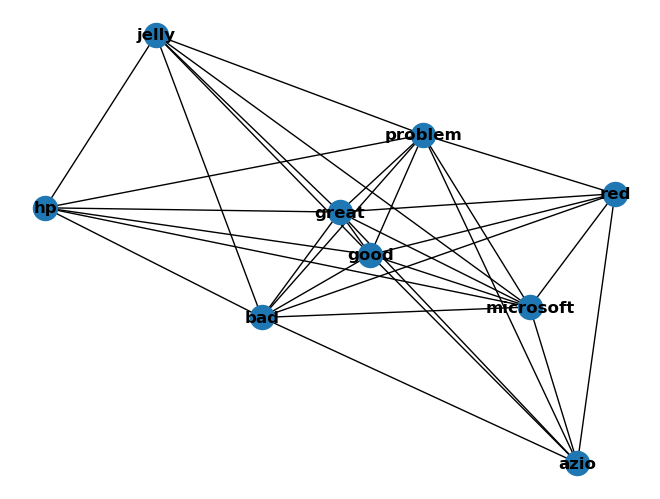

In [37]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

As we can see from the network analysis, keyboards and key are in the central, having huge connection with others, which matches with its huge frequency. It is interesting that compared with zagg, Microsoft has more connection with problems hhh. 

In [38]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [39]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')
doollda.show_topics()

[(0,
  '0.045*"keyboard" + 0.034*"key" + 0.016*"color" + 0.016*"like" + 0.014*"work" + 0.012*"light" + 0.010*"feel" + 0.008*"love" + 0.007*"type" + 0.006*"time"'),
 (1,
  '0.044*"keyboard" + 0.034*"key" + 0.019*"work" + 0.015*"mouse" + 0.012*"like" + 0.009*"buy" + 0.009*"light" + 0.008*"type" + 0.008*"use" + 0.008*"time"'),
 (2,
  '0.074*"keyboard" + 0.031*"key" + 0.016*"work" + 0.014*"type" + 0.011*"use" + 0.010*"light" + 0.009*"like" + 0.008*"love" + 0.008*"have" + 0.007*"buy"'),
 (3,
  '0.049*"keyboard" + 0.029*"key" + 0.016*"like" + 0.012*"work" + 0.012*"feel" + 0.010*"use" + 0.009*"mouse" + 0.009*"color" + 0.007*"light" + 0.007*"price"'),
 (4,
  '0.039*"key" + 0.033*"keyboard" + 0.016*"work" + 0.012*"like" + 0.012*"use" + 0.010*"type" + 0.010*"space" + 0.008*"press" + 0.007*"mouse" + 0.007*"bar"')]

In [40]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

In [41]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

microsoft [(2, 0.59714526), (4, 0.40283054)]
problem [(2, 0.5670439), (4, 0.4329203)]
great [(2, 0.57880664), (4, 0.42118633)]
bad [(2, 0.577569), (4, 0.42238897)]
good [(2, 0.56553155), (4, 0.43445885)]
hp [(2, 0.593764), (4, 0.4061637)]
red [(2, 0.5566122), (4, 0.44334787)]
azio [(2, 0.55714566), (4, 0.4426944)]
jelly [(2, 0.5682079), (4, 0.43165404)]


In [42]:
from gensim.matutils import kullback_leibler
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [43]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

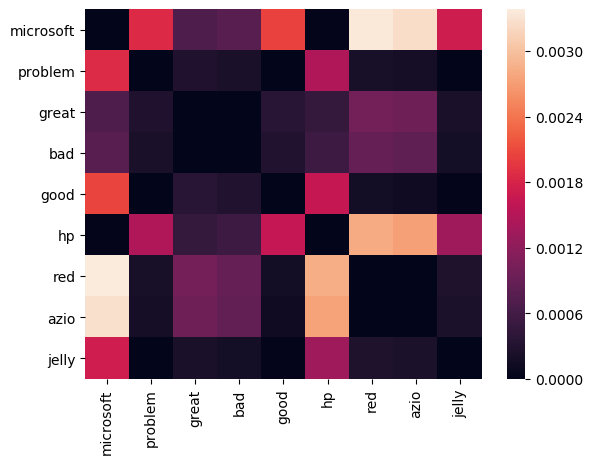

In [44]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

We can easily differ red and hp compared with other topic extraction, but hard to make a difference among other topics.

## Distance

In [57]:
df_agg = df.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
df_agg

,asin,title,reviewText
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach..."
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive..."
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...


In [58]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Divergence

In [64]:
df_agg

,asin,title,reviewText,tokenized_words,normalized_words
0,Microsoft,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach...","[As, a, software, developer, I, am, literally,...","[software, developer, literally, attached, key..."
1,HP,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...,"[Love, it, The, keys, are, placed, where, I, l...","[love, keys, placed, like, bethis, keyboard, f..."
2,Azio,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....,"[This, is, just, what, I, needed, and, it, wor...","[needed, works, great, lights, great, night, l..."
3,Redragon,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive...","[This, would, have, been, five, stars, but, I,...","[stars, received, bad, keyboard, initially, fu..."
4,Jelly Comb,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,"[I, did, n't, think, it, would, be, possible, ...","[think, possible, set, ve, day, desktop, compu..."


In [65]:
df_agg['asin'].replace('B000A6PPOK', 'Microsoft', inplace=True)
df_agg['asin'].replace('B00I0S6SK0', 'Azio', inplace=True)
df_agg['asin'].replace('B00E4TOWR0', 'HP', inplace=True)
df_agg['asin'].replace('B00LSGKEC4', 'Redragon', inplace=True)
df_agg['asin'].replace('B0194MC7JG', 'Jelly Comb', inplace=True)
df_agg['asin']

0     Microsoft
1            HP
2          Azio
3      Redragon
4    Jelly Comb
Name: asin, dtype: object

In [66]:
corpora = []
for index, row in df_agg.iterrows():
    corpora.append(row['tokenized_words'])
fileids = list(df_agg['asin']) 

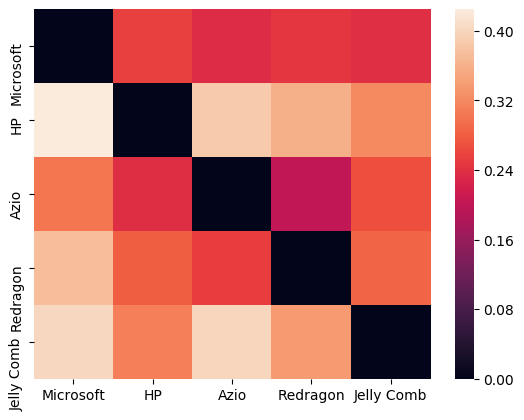

In [67]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Divergence

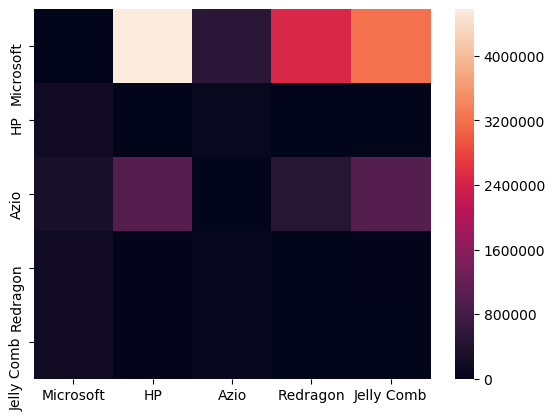

In [68]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

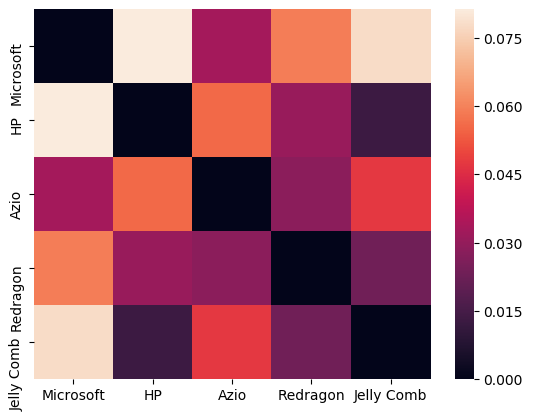

In [69]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### Wasserstein Distance

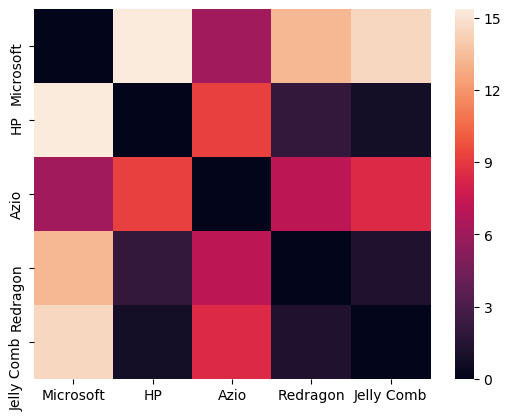

In [70]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

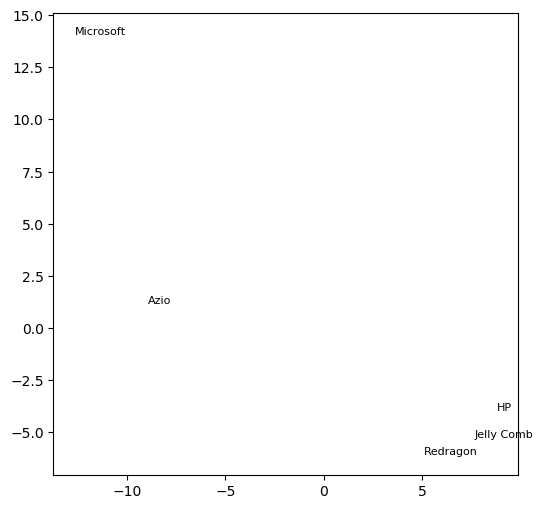

In [71]:
import sklearn.manifold #For a manifold plot
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]), size=8)